In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, make_scorer

# Import data
bank = pd.read_csv('bank-additional-full.csv', sep=';')

In [2]:
# Data exploration
print("The data set has {} rows and {} columns.".format(bank.shape[0], bank.shape[1]))

The data set has 41188 rows and 21 columns.


In [3]:
# No missing values.

print("The number of missing values in all columns:")
print(bank.isnull().sum())

The number of missing values in all columns:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [4]:
# The distribution of the target variable suggests this is an imbalanced data set.

print('The frequencies of "yes" and "no" in the label:')
for i in range(20,21):
    print(bank.iloc[:,i].value_counts())   

The frequencies of "yes" and "no" in the label:
no     36548
yes     4640
Name: y, dtype: int64


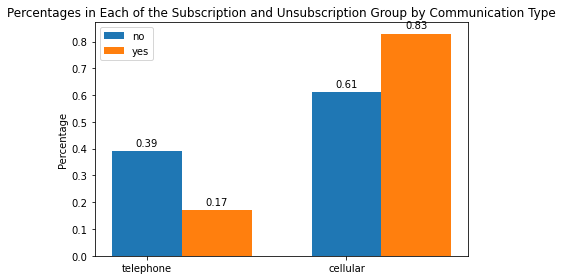

In [5]:
# Explore the relationship between the target variable and a single explanatory variable

def plot_exploratory_barchart(dataset, explanatory_variable, target_variable, width = 0.35, title = 'Percentage Plot'):
    
    """
    Plot a bar chart illustrating the percentages in each of the target subgroup by different values of the explanatory variable.
    
    Arguments:
        -- dataset: the data set.
        -- explanatory_variable: the attribute name, in string form.
        -- target_variable: the name of the target attribute, in string form.
        -- width: the width of the bars.
        -- title: the title of the plot, in string form."""
        
    labels_exp = list(dataset[explanatory_variable].unique())   # to store the unique values of the explanatory_variable
    m = len(labels_exp) # number of unique values in the explanatory_variable
        
    labels_target = list(dataset[target_variable].unique())     # to store the unique values of the target_variable
    n = len(labels_target)       # number of unique values in the target_variable
        
    # target_subgroup_lst stores n lists, each for one target subgroup.
    # for example, target_subgroup_lst = [yes, no], where yes = ['cellular_yes', 'telephone_yes'] and no = ['cellular_no', 'telephone_no'] 
    target_subgroup_lst = []
    for j in range(n):
        target_subgroup = []
        for i in range(m):
            val = dataset[explanatory_variable][(bank.y==labels_target[j]) & (bank.contact == labels_exp[i])].count()
            target_subgroup.append(val)
        target_subgroup = [round(i/sum(target_subgroup),2) for i in target_subgroup]
        target_subgroup_lst.append(target_subgroup)
            
    x = np.arange(len(labels_exp))  # the label locations
    
    fig, ax = plt.subplots()
    rects_lst = []
    for j in range(n):
        rects = ax.bar(x + j*width, target_subgroup_lst[j], label=labels_target[j], width=width)  #x + width/2,
        rects_lst.append(rects)

    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels_exp)
    ax.legend()
    
    # Add number on top of each bar
    for rects in rects_lst: 
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    fig.tight_layout()

    plt.show()
    
plot_exploratory_barchart(bank, 'contact', 'y', title = 
                          'Percentages in Each of the Subscription and Unsubscription Group by Communication Type')

For example, we can see that the contact method makes a difference in the subscription outcome.

In [6]:
# Define functions for data preprocessing.

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

def Ordinal_encoding(dataset, attr, category = 'auto'):
    
    ''' Perform One Hot Encoding on an attribute of a dataset.
    Arguments:
        -- dataset: the data set.
        -- attr: the attribute name, in string form.
        -- category: should be a list, with the ith element is encoded as i (integer). default: 'auto'.
        
    Output:
        return the dataset with added encoded attribute. And the original attribute is dropped'''
    
    enc = OrdinalEncoder(categories = [category])
    dataset[attr + '_encoded'] = enc.fit_transform(dataset[attr].values.reshape(-1,1))
    dataset.drop([attr], axis = 1,inplace=True)
    
    return dataset

def label_encoding(dataset, attr):
    
    ''' Perform Label Encoding on the target attribute of a dataset.
    Arguments:
        -- dataset: the data set.
        -- attr: the target attribute, in string form.
        
    Output:
        return the dataset with encoded target attribute, with the original attribute dropped.'''
        
    le = LabelEncoder()
    dataset[attr + '_encoded'] = le.fit_transform(dataset[attr])
    dataset.drop([attr], axis = 1,inplace=True)
    
    return dataset    

Data preprocessing. 

1. The target attribute has two values. Encode "no" and "yes" to 0 and 1, respectively.

2. The column "pdays" has too many missing values and is not useable. Drop it.

3. The column "education" is an ordinal attribute. Convert it into integers, with higher values representing higher levels of education.

4. Encode other categorical variables.

In [7]:
# encode label
bank = label_encoding(bank, 'y')   # no: 0, yes: 1

# drop unwanted columns. 'pdays' has too many missing values. 
bank.drop(['pdays'], axis = 1, inplace=True)

# preprocess ordinal variable: 'education'
bank = Ordinal_encoding(bank, 'education', ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'unknown', 'high.school','professional.course', 'university.degree'])

# convert categorical variables into numerical values
bank = label_encoding(bank, 'job')
bank = label_encoding(bank, 'marital')
bank = label_encoding(bank, 'default')
bank = label_encoding(bank, 'housing')
bank = label_encoding(bank, 'contact')
bank = label_encoding(bank, 'poutcome')
bank = label_encoding(bank, 'loan')

# encode time variables ('month', 'day_of_week')      # can be tuned. Other options are cyclical variable encoding and One-Hot encoding
bank = label_encoding(bank, 'month')
bank = label_encoding(bank, 'day_of_week')

Split data set into test set (20%) and training set (80%, including validation set, will use cross validation later).

In [8]:
import time
from sklearn.model_selection import train_test_split
from sklearn import metrics

y = bank.iloc[:,bank.columns == 'y_encoded'].values.ravel() # convert to 1D, to meet the requirement of fit_transform().
X = bank.iloc[:, bank.columns != 'y_encoded']
        
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =.20, random_state = 65, stratify = y)
from sklearn.ensemble import RandomForestClassifier

Techniques used to address the imbalanced data issue:

1. Stratify the data for training and testing.

2. Incorporating the weights of the classes into the cost function of the classifier. RandomForestClassifier in sklearn has an argument "class_weight", which penalizes the misclassification on the minority class. By setting class_weight = 'balance', sklearn sets the penalty ratio between the minority class and majority class as the inverse of the sample ratio between these two classes. 

3. Choose ROC AUC as the evaluation metric.

Evaluation metric choice:

1. Recall is important in this task because we don't want to miss the prospective clients. A relatively high false positive rate is acceptable because although these clients do not subscribe now, they may subscribe in the near future if our sales staff keep following up.

2. Precision-recall AUC seems not suitable for these data after experiments. ROC AUC works quite well. Therefore, ROC AUC is selected as the evaluation metric.

Strategy of hyperparameter search: First perform search in a wide range of values, then narrow the range to a more focused area around the best performing hyperparameter values.

In [9]:
# Perform grid search for optimal hyperparameter search

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

classifier = RandomForestClassifier(class_weight = 'balanced', n_jobs = -1, oob_score = True)

parameters = {'n_estimators': [250, 350], 'max_depth': [5, 6], 'max_features': ["sqrt", "log2"],
              'min_samples_split': [5, 20], 'min_samples_leaf': [10, 20]}

scoring = {
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score)   
  }

nfolds = 3

gs = GridSearchCV(estimator = classifier, param_grid = parameters, scoring = scoring,  
                        refit = 'roc_auc', cv = nfolds, return_train_score = True)
search = gs.fit(X_train, y_train)

results = pd.DataFrame(search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,...,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
0,2.673262,1.343248,0.163373,0.060227,5,sqrt,10,5,250,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",...,0.882375,0.878883,0.878299,0.003590,24,0.887480,0.881533,0.883848,0.884287,0.002448
1,2.327981,0.118710,0.248376,0.002140,5,sqrt,10,5,350,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",...,0.882073,0.881558,0.879131,0.003803,21,0.886924,0.881478,0.885172,0.884525,0.002270
2,1.657593,0.039451,0.211616,0.053863,5,sqrt,10,20,250,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",...,0.884301,0.881577,0.879989,0.004318,19,0.887737,0.883364,0.883829,0.884976,0.001961
3,2.231664,0.079081,0.245435,0.007977,5,sqrt,10,20,350,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",...,0.884049,0.882533,0.880736,0.003666,16,0.887698,0.882892,0.885541,0.885377,0.001965
4,1.600431,0.047613,0.127113,0.001529,5,sqrt,20,5,250,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",...,0.880347,0.879024,0.877931,0.002540,25,0.887277,0.880256,0.882463,0.883332,0.002931


In [10]:
# Examine the best model 
best_rf = RandomForestClassifier(n_estimators = 350, class_weight = 'balanced', n_jobs = -1, oob_score = True, max_depth= 6,
                                    min_samples_split=10, min_samples_leaf=5)
best_rf.fit(X_train,y_train)
y_pred = best_rf.predict(X_test)
y_score = best_rf.predict_proba(X_test)[:,1]

recall = recall_score(y_test, y_pred) 
roc_auc = roc_auc_score(y_test, y_score) 
cm = confusion_matrix(y_test, y_pred) 
print('roc_auc: ', roc_auc)
print('recall: ', recall)
print('confusion_matrix: ')
print(cm)

roc_auc:  0.9398171788763621
recall:  0.9331896551724138
confusion_matrix: 
[[6103 1207]
 [  62  866]]


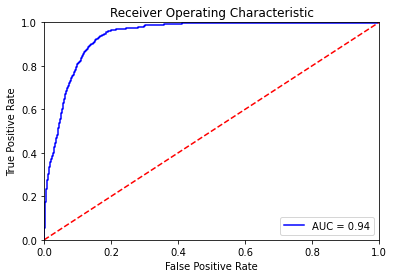

In [11]:
# Plot ROC of the best model
y_prob = best_rf.predict_proba(X_test)[:,1]   
fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

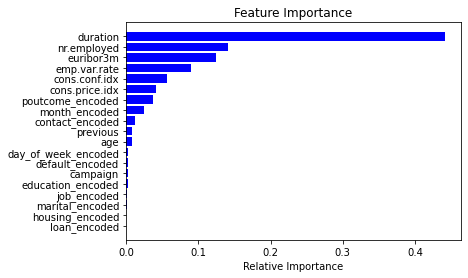

In [12]:
# Feature importance of the best model
features = X_test.columns.values.tolist()
importance = best_rf.feature_importances_  
indices = np.argsort(importance)

plt.title('Feature Importance')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Random Forest has good interpretability, good performance and is computationally efficient.